# Assignment 6: Apply NB

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
from scipy import sparse

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import math
from prettytable import PrettyTable

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [3]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('/content/drive/MyDrive/Dataset/preprocessed_data.csv')

print(data.shape)

#data.head(3)

(109248, 9)


In [4]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


##<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

Numerical Features:

- Price
- teacher_number_of_previously_projects

Categorical Features
- school_state
- teacher_prefix
- project_grade_category
- clean_categories
- clean_sub_categories

Text Features
 - essay




In [6]:
# 1. Split your data.

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'],axis = 1)

print(X.shape, y.shape, 'This is X and y ')

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size = 0.3 ,random_state = 10)

print(X_train.shape,X_test.shape, 'This is X train and test')
print(y_train.shape,y_test.shape,'This is  y train and test')

(109248, 8) (109248,) This is X and y 
(76473, 8) (32775, 8) This is X train and test
(76473,) (32775,) This is  y train and test


## 1.3 Encoding Text Features

In [7]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [8]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)



In [9]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)


vect1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features = 5000)
vect1.fit(X_train['essay'])
X_train_preprocessed_essay_bow = vect1.transform(X_train['essay'])

X_test_preprocessed_essay_bow = vect1.transform(X_test['essay'])

print("Shape after Transform")
print(X_train_preprocessed_essay_bow.shape)
print(X_test_preprocessed_essay_bow.shape)

Shape after Transform
(76473, 5000)
(32775, 5000)


In [10]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)


vect2 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features = 5000)
vect2.fit(X_train['essay'])
X_train_preprocessed_essay_tfidf = vect2.transform(X_train['essay'])

X_test_preprocessed_essay_tfidf = vect2.transform(X_test['essay'])

print("Shape after Transform")
print(X_train_preprocessed_essay_tfidf.shape)
print(X_test_preprocessed_essay_tfidf.shape)



Shape after Transform
(76473, 5000)
(32775, 5000)


##<h2>1.4 Make Data Model Ready: encoding categorical features</h2>

In [11]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().

# School_state
print('School State')

vect = CountVectorizer()
vect_ss = vect.fit(X_train['school_state'].values)
X_train_school_state = vect.fit_transform(X_train['school_state'].values)
X_test_school_state = vect.transform(X_test['school_state'].values)

print('X_train shape:' ,X_train_school_state.shape)
print('X_test_shape:', X_test_school_state.shape)

print('\n')

# Teacher_prefix
print('Teacher Prefix')

vect = CountVectorizer()
vect_tp = vect.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix = vect.fit_transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = vect.transform(X_test['teacher_prefix'].values)

print('X_train shape:' ,X_train_teacher_prefix.shape)
print('X_test_shape:', X_test_teacher_prefix.shape)

print('\n')


print('Project_grade_category')

vect = CountVectorizer()

vect_pgc = vect.fit(X_train['project_grade_category'].values)
X_train_pgc = vect.fit_transform(X_train['project_grade_category'].values)
X_test_pgc = vect.transform(X_test['project_grade_category'].values)

print('X_train shape:' ,X_train_pgc.shape)
print('X_test_shape:', X_test_pgc.shape)

print('\n')

print('Clean_category')

vect = CountVectorizer()

vect_cc = vect.fit(X_train['clean_categories'].values)
X_train_cc = vect.fit_transform(X_train['clean_categories'].values)
X_test_cc = vect.transform(X_test['clean_categories'].values)

print('X_train shape:' ,X_train_cc.shape)
print('X_test_shape:', X_test_cc.shape)

print('\n')

print('Clean_subcategory')

vect = CountVectorizer()

vect_cs = vect.fit(X_train['clean_subcategories'].values)
X_train_cs = vect.fit_transform(X_train['clean_subcategories'].values)
X_test_cs = vect.transform(X_test['clean_subcategories'].values)

print('X_train shape:' ,X_train_cs.shape)
print('X_test_shape:', X_test_cs.shape)

X_train_cat = hstack((X_train_school_state,X_train_teacher_prefix,X_train_pgc,X_train_cc,X_train_cs)).tocsr()
X_test_cat = hstack((X_test_school_state,X_test_teacher_prefix,X_test_pgc,X_test_cc,X_test_cs)).tocsr()

print('\n')
print('Th final categorical variables')
print('X_train_cat shape:' ,X_train_cat.shape)
print('X_test_cat shape:', X_test_cat.shape)

School State
X_train shape: (76473, 51)
X_test_shape: (32775, 51)


Teacher Prefix
X_train shape: (76473, 5)
X_test_shape: (32775, 5)


Project_grade_category
X_train shape: (76473, 4)
X_test_shape: (32775, 4)


Clean_category
X_train shape: (76473, 9)
X_test_shape: (32775, 9)


Clean_subcategory
X_train shape: (76473, 30)
X_test_shape: (32775, 30)


Th final categorical variables
X_train_cat shape: (76473, 99)
X_test_cat shape: (32775, 99)


## 1.5 Encoding Numerical Features 

In [12]:
#Normlaizer 
# By default works on row not on column like standardscaler
#So transfrom the to row form then transform using 1 -1 which is 1 row and numb of cols

#Numerical Feature

print('For Price Feature')

norm = Normalizer()
norm.fit(X_train['price'].values.reshape(-1,1)) #Converts to 
X_train_price_norm = norm.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = norm.transform(X_test['price'].values.reshape(-1,1))


print('X_train_price shape_norm',X_train_price_norm.shape)
print('X_test_price shape_norm',X_test_price_norm.shape)
print('\n')

print('For Teacher number of previously posted projects')

norm = Normalizer()
X_test_pp = norm.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_pp = norm.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_pp = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('X_train_pp',X_train_pp.shape)
print('X_test_pp',X_test_pp.shape)




For Price Feature
X_train_price shape_norm (76473, 1)
X_test_price shape_norm (32775, 1)


For Teacher number of previously posted projects
X_train_pp (76473, 1)
X_test_pp (32775, 1)


##<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## Set 1

In [13]:
#Data
X_train = hstack((X_train_preprocessed_essay_bow,X_train_cat,X_train_price_norm,X_train_pp)).tocsr()
X_test = hstack((X_test_preprocessed_essay_bow,X_test_cat,X_test_price_norm,X_test_pp)).tocsr()

print('Train',X_train.shape,'y:',y_train.shape)
print('Test',X_test.shape,'y:',y_test.shape)

Train (76473, 5101) y: (76473,)
Test (32775, 5101) y: (32775,)


In [14]:
#Training model
model = MultinomialNB(class_prior = [0.5,0.5])
alpha_values = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
param = {'alpha':alpha_values}

#Iinstantiate grid
grid = GridSearchCV(model,param, scoring='roc_auc',cv= 5,return_train_score= True)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [15]:
train_auc = grid.cv_results_['mean_train_score']
train_auc_std = grid.cv_results_['std_train_score']

cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std = grid.cv_results_['std_test_score']

In [16]:
alpha_values = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
alpha  = [math.log10(i) for i in alpha_values]
#print(alpha)

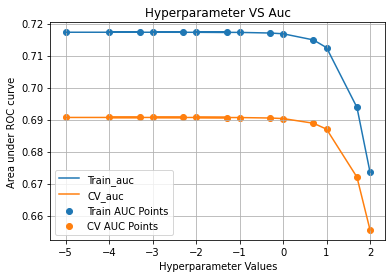

In [17]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot3

plt.plot(alpha,train_auc,label = 'Train_auc')
plt.plot(alpha,cv_auc,label = 'CV_auc')

plt.scatter(alpha,train_auc,label='Train AUC Points')
plt.scatter(alpha,cv_auc,label='CV AUC Points')

plt.xlabel('Hyperparameter Values')
plt.ylabel("Area under ROC curve")
plt.title("Hyperparameter VS Auc")
plt.legend()
plt.grid()

In [18]:
#From graph we have maximum AUC and leats gap at approx alpha = 0.5
print('The best alphh after trainin:',grid.best_params_)

#Getting the auc score at highest alpha
print('AUC score of the best alpha:',grid.best_score_)

The best alphh after trainin: {'alpha': 1e-05}
AUC score of the best alpha: 0.6906557619488548


###Testing performance on Test and plotting ROC for train and test

In [19]:
model = MultinomialNB(alpha = grid.best_params_['alpha'],class_prior = [0.5,0.5])
model.fit(X_train,y_train)

MultinomialNB(alpha=1e-05, class_prior=[0.5, 0.5])

Train AUC  0.7125686358152559
Test AUC  0.6834340080930832


1e-05

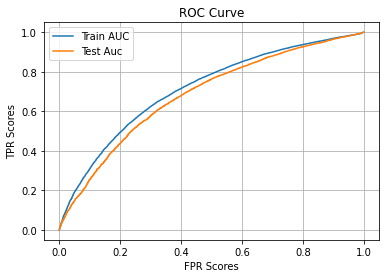

In [20]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
#Choosing the best parameters from grid search to train the model
 

model = MultinomialNB(alpha = grid.best_params_['alpha'],class_prior = [0.5,0.5])
model.fit(X_train,y_train)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
y_train_prob = model.predict_proba(X_train)[:,1]
y_test_prob = model.predict_proba(X_test)[:,1]

train_fpr,train_tpr,train_thresholds = roc_curve(y_train,y_train_prob)

test_fpr,test_tpr,test_thresholds = roc_curve(y_test,y_test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC')
plt.plot(test_fpr,test_tpr,label = 'Test Auc')
plt.title('ROC Curve')
plt.xlabel('FPR Scores')
plt.ylabel('TPR Scores')
plt.legend()
plt.grid()

print('Train AUC ',auc(train_fpr,train_tpr))
print('Test AUC ',auc(test_fpr,test_tpr))
grid.best_params_['alpha']


In [21]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t


# Predicting output with threshold from least fpr
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [22]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_prob, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_prob, best_t)))

the maximum value of tpr*(1-fpr) 0.43984773984713327 for threshold 0.492
Train confusion matrix
[[ 7838  3741]
 [22727 42167]]
Test confusion matrix
[[ 3180  1783]
 [ 9958 17854]]


## Set 2

In [23]:
#Data 

X_train = hstack((X_train_preprocessed_essay_tfidf,X_train_cat,X_train_price_norm,X_train_pp)).tocsr()
X_test = hstack((X_test_preprocessed_essay_tfidf,X_test_cat,X_test_price_norm,X_test_pp)).tocsr()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (76473, 5101)
X_test shape: (32775, 5101)


In [24]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot


alpha_values = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

model = MultinomialNB(class_prior =[0.5,0.5])
param = {'alpha':alpha_values}
grid = GridSearchCV(model,param, scoring = 'roc_auc',cv = 5,return_train_score = True)
grid.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

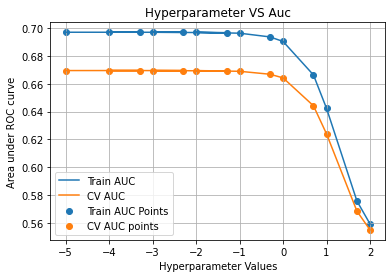

In [25]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

train_score = grid.cv_results_['mean_train_score']
val_score = grid.cv_results_['mean_test_score']

alpha = [math.log10(i) for i in alpha_values]

plt.plot(alpha,train_score,label = 'Train AUC')
plt.plot(alpha,val_score,label='CV AUC')
plt.scatter(alpha,train_score,label  = 'Train AUC Points')
plt.scatter(alpha,val_score,label = 'CV AUC points')
plt.xlabel('Hyperparameter Values')
plt.ylabel("Area under ROC curve")
plt.title("Hyperparameter VS Auc")
plt.grid()
plt.legend()


In [26]:
#From graph we have maximum AUC and leats gap at approx alpha = 0.5
print('The best alphh after trainin:',grid.best_params_)

#Getting the auc score at highest alpha
print('AUC score of the best alpha:',grid.best_score_)

The best alphh after trainin: {'alpha': 1e-05}
AUC score of the best alpha: 0.6694005297402958


Train AUC  0.6921893423796579
Test AUC  0.6654928261164836
1e-05


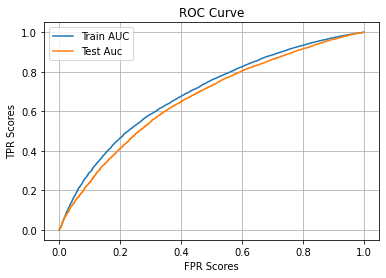

In [27]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

model = MultinomialNB(alpha = grid.best_params_['alpha'],class_prior = [0.5,0.5])
model.fit(X_train,y_train)

y_train_prob = model.predict_proba(X_train)[:,1]
y_test_prob = model.predict_proba(X_test)[:,1]

train_fpr,train_tpr, train_thres = roc_curve(y_train,y_train_prob)
test_fpr,test_tpr, test_thres = roc_curve(y_test,y_test_prob)

plt.plot(train_fpr,train_tpr,label = 'Train AUC')
plt.plot(test_fpr,test_tpr,label = 'Test Auc')
plt.title('ROC Curve')
plt.xlabel('FPR Scores')
plt.ylabel('TPR Scores')
plt.legend()
plt.grid()


print('Train AUC ',auc(train_fpr,train_tpr))
print('Test AUC ',auc(test_fpr,test_tpr))
print(grid.best_params_['alpha'])


In [28]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_prob, best_t)))

print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_prob, best_t)))


the maximum value of tpr*(1-fpr) 0.4123565655693785 for threshold 0.534
Train confusion matrix
[[ 8293  3286]
 [27944 36950]]
Test confusion matrix
[[ 3409  1554]
 [12152 15660]]


##20 features

In [29]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
#https://numpy.org/doc/stable/reference/generated/numpy.take.html
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)

#Creating list for adding all features the using argsort to find them

features = []

for i in vect1.get_feature_names():
  features.append(i)

for i in vect_ss.get_feature_names():
  features.append(i)

for i in vect_tp.get_feature_names():
  features.append(i)

for i in vect_pgc.get_feature_names():
  features.append(i)

for i in vect_cc.get_feature_names():
  features.append(i)

for i in vect_cs.get_feature_names():
  features.append(i)


features.append('price')
features.append('teacher_number_of_previously_posted_projects')


print(len(features))



5101


In [42]:
#Argsor is in ascending using indexing to take 20 feature from back
#Using feature_log_prob to filter max feature

top_20_class_0 = np.take(features,model.feature_log_prob_[0,:].argsort()[-20:] )
print('top_20_class_0:', top_20_class_0)
print('\n')
top_20_class_1 = np.take(features,model.feature_log_prob_[1,:].argsort()[-20:] )
print('top_20_class_1:', top_20_class_1)


top_20_class_0: ['grades_9_12' 'appliedsciences' 'students' 'appliedlearning' 'ca'
 'health_sports' 'specialneeds' 'specialneeds' 'grades_6_8'
 'literature_writing' 'literacy' 'mathematics' 'grades_3_5' 'ms'
 'math_science' 'grades_prek_2' 'literacy_language' 'mrs'
 'teacher_number_of_previously_posted_projects' 'price']


top_20_class_1: ['appliedsciences' 'grades_9_12' 'appliedlearning' 'specialneeds'
 'specialneeds' 'students' 'health_sports' 'ca' 'grades_6_8'
 'literature_writing' 'mathematics' 'literacy' 'grades_3_5' 'ms'
 'math_science' 'grades_prek_2' 'literacy_language' 'mrs'
 'teacher_number_of_previously_posted_projects' 'price']


##<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [35]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

myTable = PrettyTable(["Model", "Vectorizer", "Hyperameter", "Train AUC","Test AUC"])
myTable.add_row(["NB", "BOW", "1e-05","71.2 %", "68.3 %"])
myTable.add_row(["NB", "TFIDF", "1e-05", "67.1 %","67 %"])

print(myTable)



+-------+------------+-------------+-----------+----------+
| Model | Vectorizer | Hyperameter | Train AUC | Test AUC |
+-------+------------+-------------+-----------+----------+
|   NB  |    BOW     |    1e-05    |   71.2 %  |  68.3 %  |
|   NB  |   TFIDF    |    1e-05    |   67.1 %  |   67 %   |
+-------+------------+-------------+-----------+----------+


Conclusion:

- Final Models:
 - Set 1: Train Auc: 71.2 %   Test Auc: 68.3%     alpha: 1e-05
 - Set 2: Train Auc: 67.1 %   Test Auc: 67%     alpha:1e-05

- From the table we can conclude that the tfidf is better fit than BOW vectorization as the train and test auc are almost similar.

- Also the test auc of BOW is slightly greater than TFIDF Vectorizer but the gap is more between the train and test auc

- Both  the models get the values of alpha as 1e-05 

- The accuracy remains almost same when we consider all the feature and when we consider 80k points.


- The top features for both the classes are aslo almost similar.

- To further increase accuracy we need to work on feature engineering.